# Convergent approaches to AI Explainability for HEP muonic particles pattern recognition

# 1) xAI based on Attribution methods and Saliency Maps

The aim of this notebook is to provide explainability for CNNs using algorithms from the **Attribution methods** family adapted to our task of regression. We have studied and compared three different methods:
1. **Class Activation Map (CAM)** or, more particularly, [**Regression Activation Map (RAM)**](https://arxiv.org/pdf/1703.10757.pdf);
2. [**Integrated Gradients**](https://arxiv.org/pdf/1703.01365.pdf), a *Features Attribution* method that focuses on reinforcing the **Sensitivity** and **Implementation Invariance** axioms;
3. [**SmoothGrad**](https://arxiv.org/abs/1706.03825.pdf), able to create robust heatmaps by adding and removing random noise.

## Environment setup

### Importing libraries

In [1]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras.models import Model
import random
from tqdm import tqdm
import matplotlib.pyplot as plt

from models.cnn import build_cnn
from utils.metrics import spread, efficiency
from utils.plot import plot_history, plot_cm, plot_explanation
from attribution.attribution import ram_per_feature, interpolate_image, add_noise, smoothgrad, get_heatmaps

random.seed(0)

print('Libraries imported')

### Downloading data

In [2]:
# get data from my Drive, it downloads (and unzip) less stuff (i.e. only the used one) and data are already splitted
# ! rm -rf sample_data
# ! pip install --upgrade --no-cache-dir gdown -q
# ! gdown --id 1s6JZuJPAqUtnnvezDepApE4BMKo3FP4q
# print('\nUnzipping data...')
# ! unzip -q muontriggerdata-master.zip
# ! rm -rf muontriggerdata-master.zip

print('\nLoading images with noise...')
train_images = np.load('../muontriggerdata-master/train_images_with_noise.npy')
test_images = np.load('../muontriggerdata-master/test_images_with_noise.npy')

print('\nLoading images without noise...')
train_images_without_noise = np.load('../muontriggerdata-master/train_images_without_noise.npy')
test_images_without_noise = np.load('../muontriggerdata-master/test_images_without_noise.npy')

print('\nLoading labels...')
train_labels = np.load('../muontriggerdata-master/train_labels.npy')
test_labels = np.load('../muontriggerdata-master/test_labels.npy')

print('\nLoading completed.')

## Data Preprocessing

In [3]:
# checking shapes of npy arrays
print(train_images.shape)
print(test_images.shape)

print(train_images_without_noise.shape)
print(test_images_without_noise.shape)

print(train_labels.shape)
print(test_labels.shape)

In [4]:
train_labels_df = pd.DataFrame(train_labels, columns=['pt', 'eta', 'phi', '0', 'nhits'])
test_labels_df = pd.DataFrame(test_labels, columns=['pt', 'eta', 'phi', '0', 'nhits'])

Our work is focused **ONLY** on predicting values for *pt* and *eta*; therefore, we will drop the remaining parameters in the labels.

In [5]:
train_labels_df = train_labels_df.drop(columns=['phi', '0', 'nhits'])
test_labels_df = test_labels_df.drop(columns=['phi', '0', 'nhits'])

## Regression with a generic CNN

### Customized metrics definition

According to our instructions, we want a model able to select muons with $pt$ greater than a fixed threshold ($\ge 10$ GeV) with the highest possible efficiency. Moreover, it should be able to discard muons with $pt$ lower than such threshold ($< 10$ GeV).

We can do that by defining two metrics:
* **spread**, distribution of the quantity $(pt_{true} - pt_{pred})$ around the threshold of $10$ GeV (let's say $[7-8, 12-13]$ GeV). This metric should be as low as possible.
* **efficiency**, number of muons with $pt_{true} > 15$ GeV and $pt_{pred} > 15$ GeV over the number of muons with $pt_{true} > 15$ GeV. This metric should be as high as possible.

Therefore, we will create our customized metrics to be used in the ```model.compile``` method in a while.



### Definition and training

Creating a simple CNN to first solve the regression task.

In [ ]:
model = build_cnn()
model.compile(loss='mae',
              metrics=[spread, efficiency],
              optimizer='adam')
model.summary()

In [ ]:
efficiency_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath='cnn_model',
    save_weights_only=True,
    monitor='val_efficiency',
    mode='max',
    save_best_only=True)

history = model.fit(x=train_images,
                    y=train_labels_df,
                    batch_size=32,
                    epochs=30,
                    callbacks=[efficiency_callback],
                    validation_data=(test_images, test_labels_df))

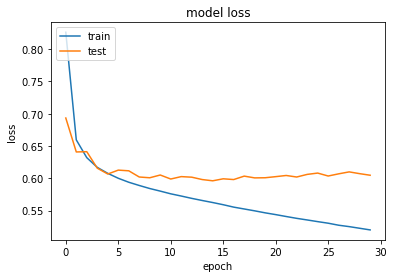

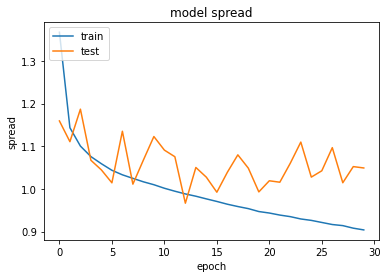

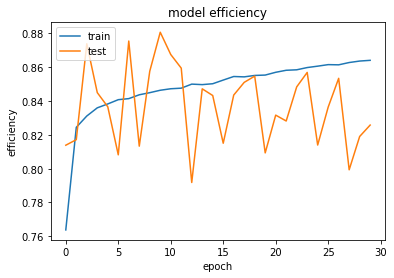

In [ ]:
plot_history(history)

In [ ]:
model.save_weights('cnn_model', save_format='tf')
print('Model weights saved')

### Evaluation

Evaluating such architecture.

In [6]:
model = build_cnn()
model.load_weights('ckpts/cnn_model/cnn_model')

model.compile(loss='mae',
              metrics=[spread, efficiency],
              optimizer=tf.keras.optimizers.legacy.Adam())
model.evaluate(x=test_images, y=test_labels_df)

2952/2952 [==============================] - 23s 6ms/step - loss: 0.6027 - spread: 1.1176 - efficiency: 0.8838


[0.6051385998725891, 1.1227219104766846, 0.8807213306427002]

In [10]:
# inspect first 10 results
y_hat = model.predict(test_images)

pred_df = pd.DataFrame(y_hat, columns=['pt_pred', 'eta_pred'])
frames = [test_labels_df, pred_df]
compare_df = pd.concat(frames, axis=1)
compare_df.head(10)

,pt,eta,pt_pred,eta_pred
0,13.491201,0.053108,15.440893,0.097523
1,4.227651,0.205530,4.146952,0.235498
2,13.979775,0.651565,13.077582,0.582433
3,14.510050,0.939512,12.413088,0.340106
4,10.261550,0.116171,9.942080,0.111001
5,18.524986,0.279401,17.896172,0.359144
6,6.452104,0.492939,6.654446,0.659508
7,15.881395,0.705206,16.456560,0.756881
8,9.464007,0.130429,9.923572,0.424438
9,11.706838,0.358624,10.529286,0.399123


## CNN Explainability

Each of the three proposed methods requires specific preliminar actions and, before comparing their effectiveness, we need to study or implement some characteristics.

### 1. Regression Activation Maps (RAM)

We now need to define a new model from the one trained on the task. In particular, such model takes as input images (as before) but outputs both the output from the last convolutional layer and from the last dense layer (that performs regression) to extract, respectively, features and results for the predicted input image.

In [8]:
model = build_cnn()
model.load_weights('ckpts/cnn_model/cnn_model').expect_partial()

# the RAM model will output the features from the last conv layer (index = -5)
# and the output from the last dense layer (= results from the regression) (index = -1)
ram_model = Model(inputs=model.input, outputs=(model.layers[-5].output, model.layers[-1].output))

### 2. Integrated Gradients (IG)

IG is based on two preliminarities:
- create a *baseline*, namely an image with all zero-ed pixels;
- implement an *interpolation* routine to create a sequence of images from the baseline to the original to explain.

Here is the baseline.

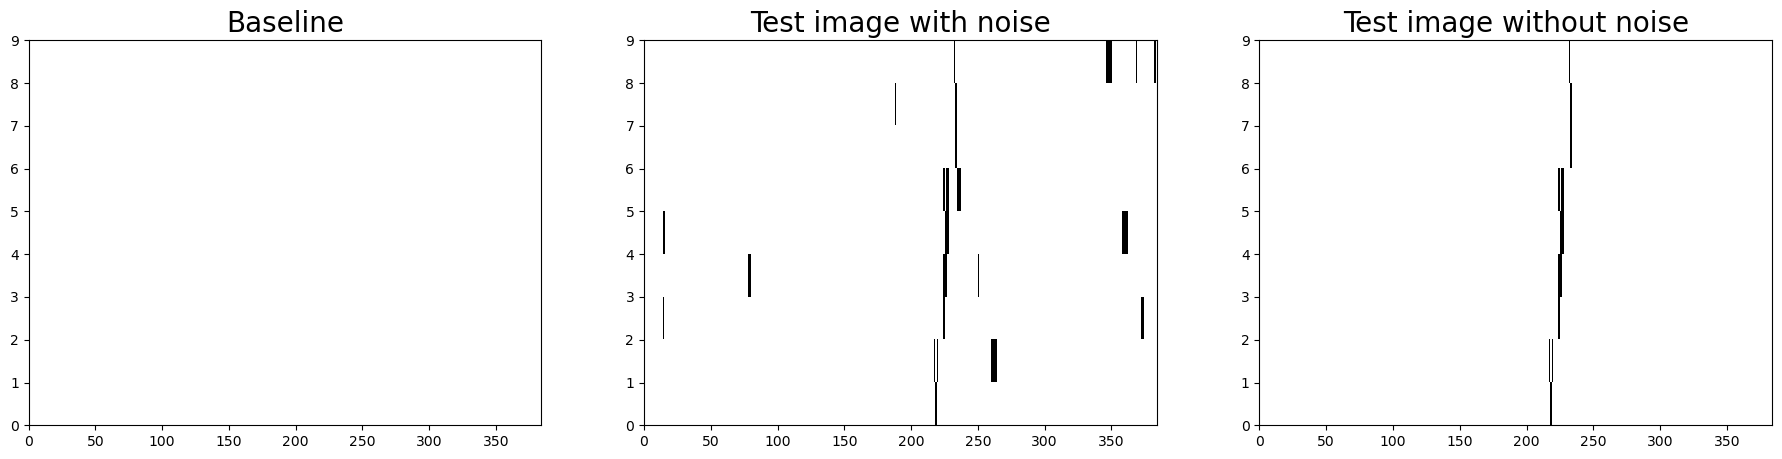

In [9]:
baseline = np.zeros_like(test_images[2])

plt.figure(figsize=(7.5*3, 5))

plt.subplot(131); plt.imshow(baseline < 0.5, aspect='auto', extent=(0, 384, 0, 9), cmap=plt.get_cmap('gray'), vmin=0, interpolation='none'); plt.title('Baseline', fontsize=20)
plt.subplot(132); plt.imshow(test_images[2] < 0.5, aspect='auto', extent=(0, 384, 0, 9), cmap=plt.get_cmap('gray'), interpolation='none'); plt.title('Test image with noise', fontsize=20)
plt.subplot(133); plt.imshow(test_images_without_noise[2] < 0.5, aspect='auto', extent=(0, 384, 0, 9), cmap=plt.get_cmap('gray'), interpolation='none'); plt.title('Test image without noise', fontsize=20)

plt.show()

We customize the interpolation in order to create a sequence of interpolated images by iteratively add new light pixels from the original image.

For instance, let's visualize one example where we have an image composed by $18$ pixels and see the evolution of our interpolated sequence.

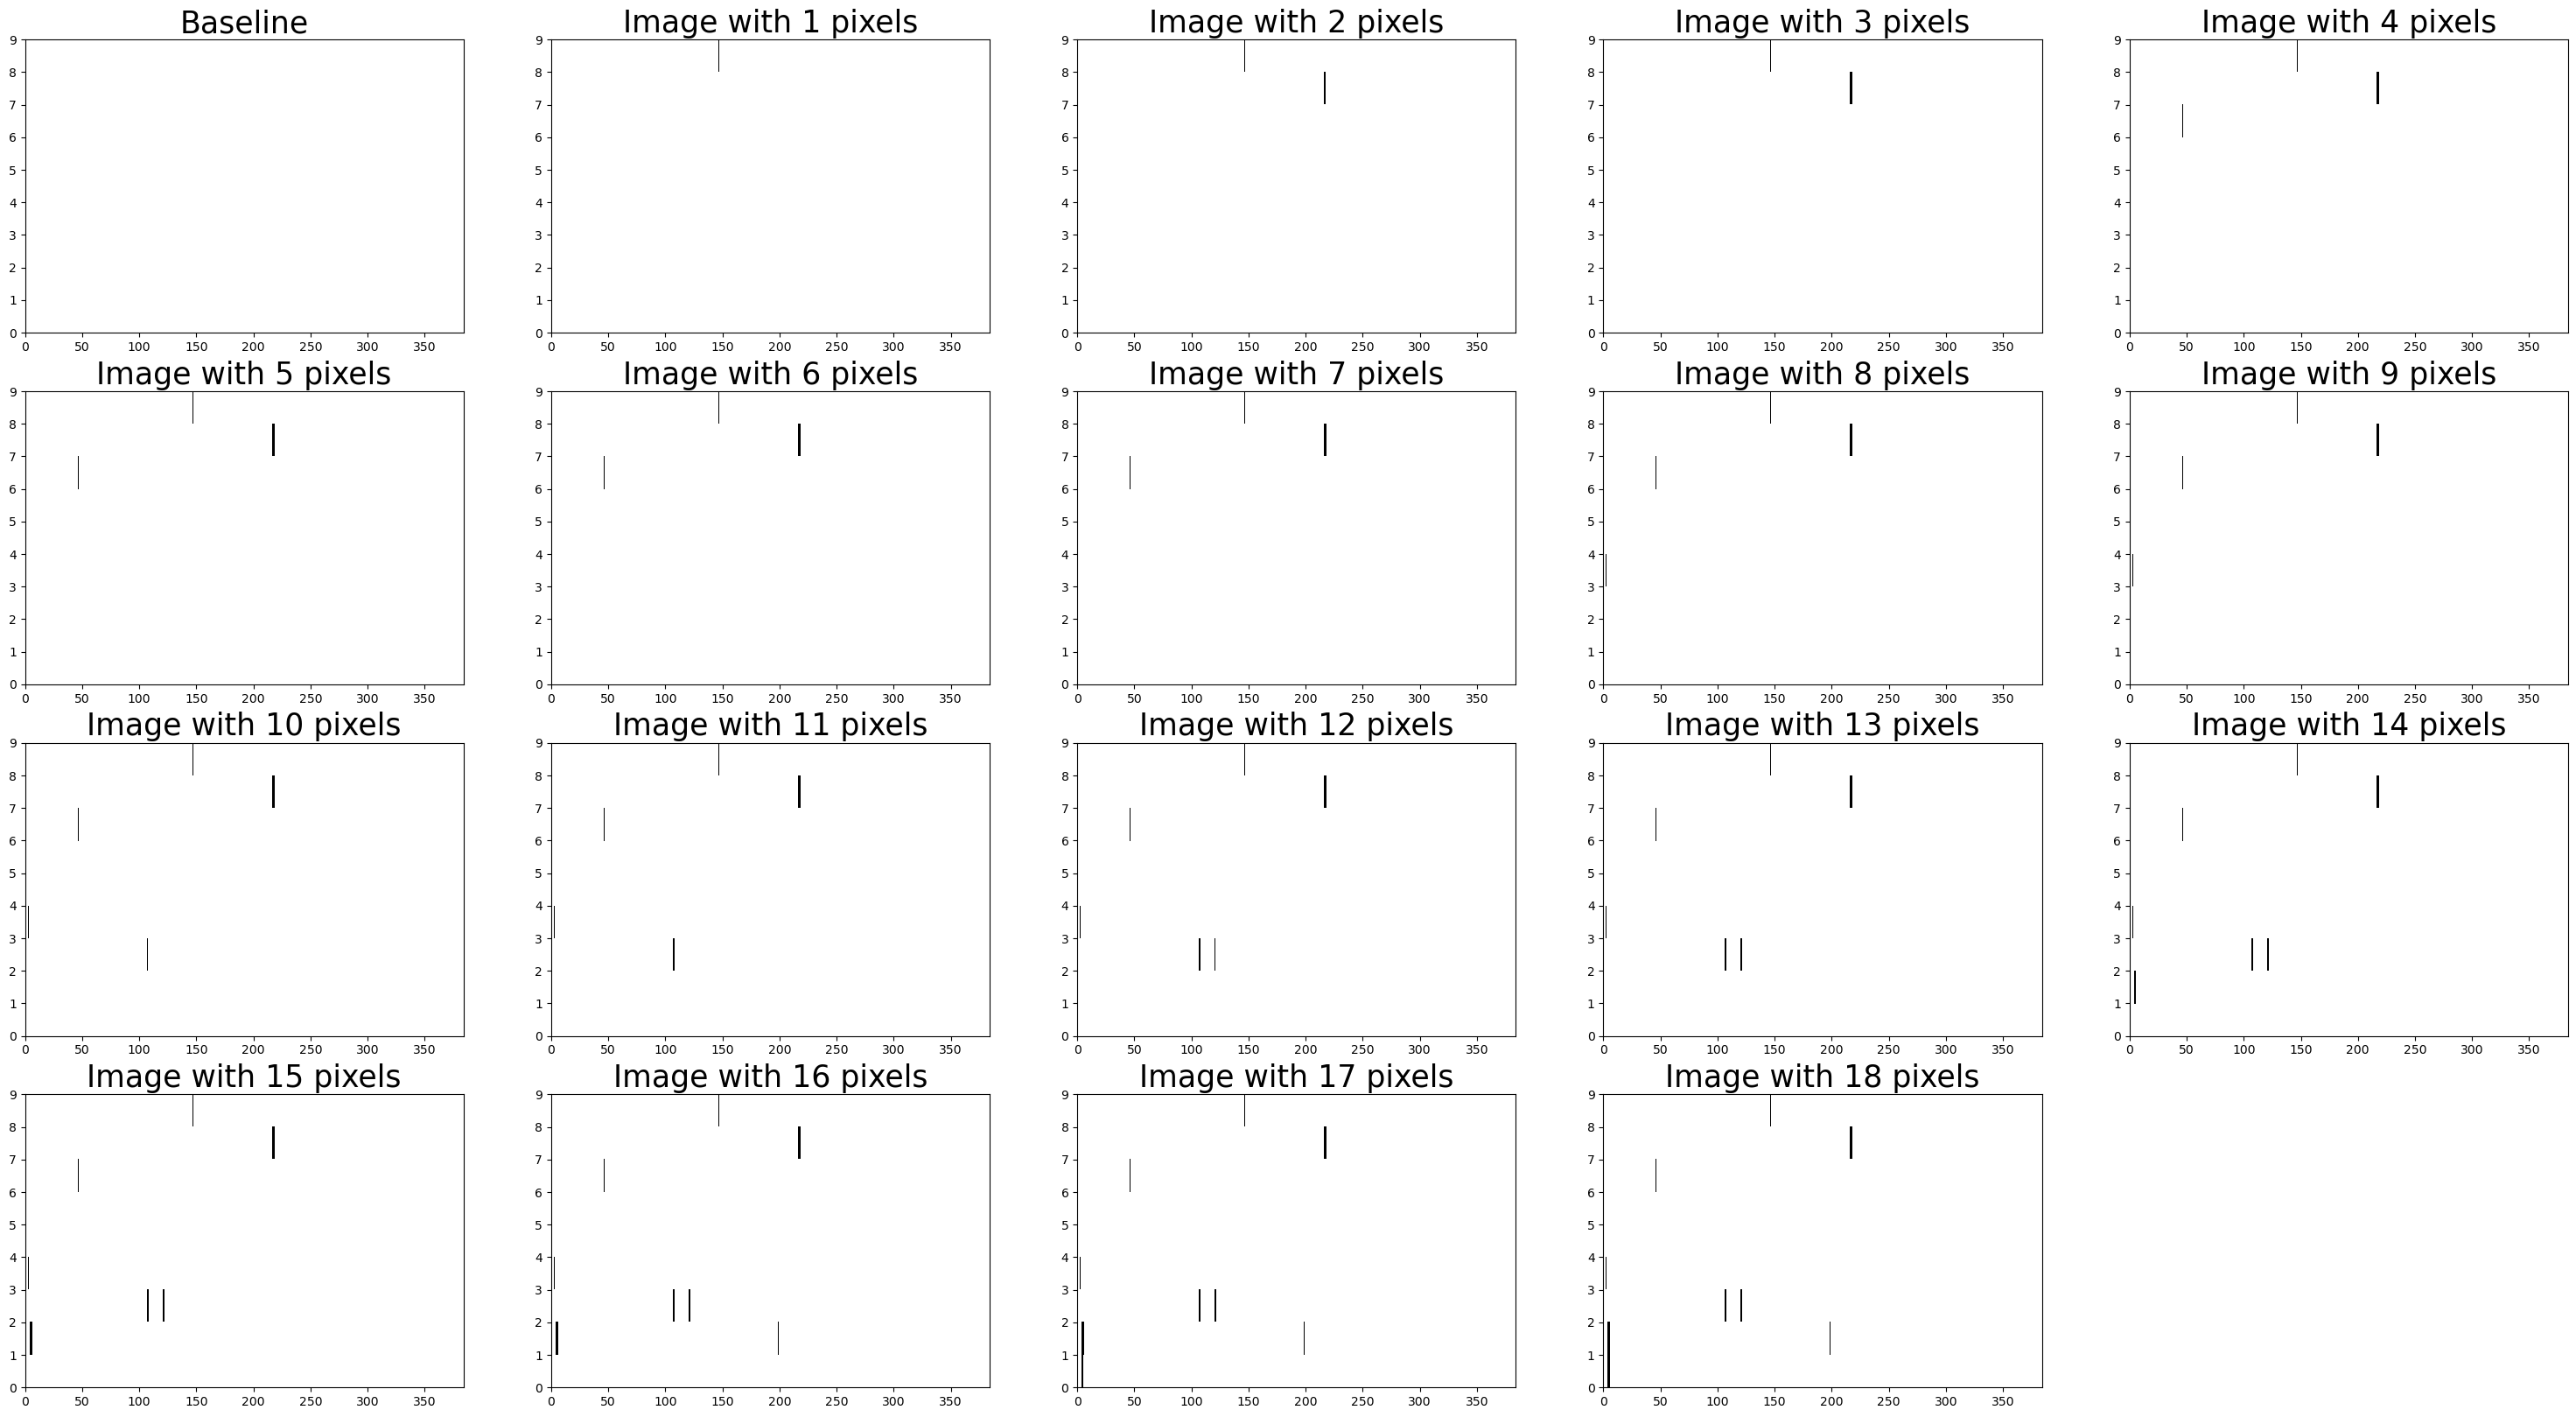

In [11]:
interpolated_images = interpolate_image(test_images[0])

plt.figure(figsize=(7.5*5, 5*4))
for i, image in enumerate(interpolated_images):
    plt.subplot(4, 5, i+1)
    plt.imshow(image < 0.5, aspect='auto', extent=(0, 384, 0, 9), cmap=plt.get_cmap('gray'), vmin=0, interpolation='none')
    plt.title('Baseline' if i == 0 else f'Image with {i} pixels', fontsize=25)
    
plt.savefig('interpolation.jpg', dpi=300, bbox_inches='tight')
plt.show()

### 3. SmoothGrad (SG)

SG requires a method to add random noise. In the original paper, they use Gaussian noise but, due to the peculiarity of our use-case with binary image, we can use *salt-and-pepper* noise to add random $1$ in the image.

Noise percent = 0.5% ==> actual added percent = 0.492%
Noise percent = 1.0% ==> actual added percent = 1.013%
Noise percent = 2.0% ==> actual added percent = 1.707%


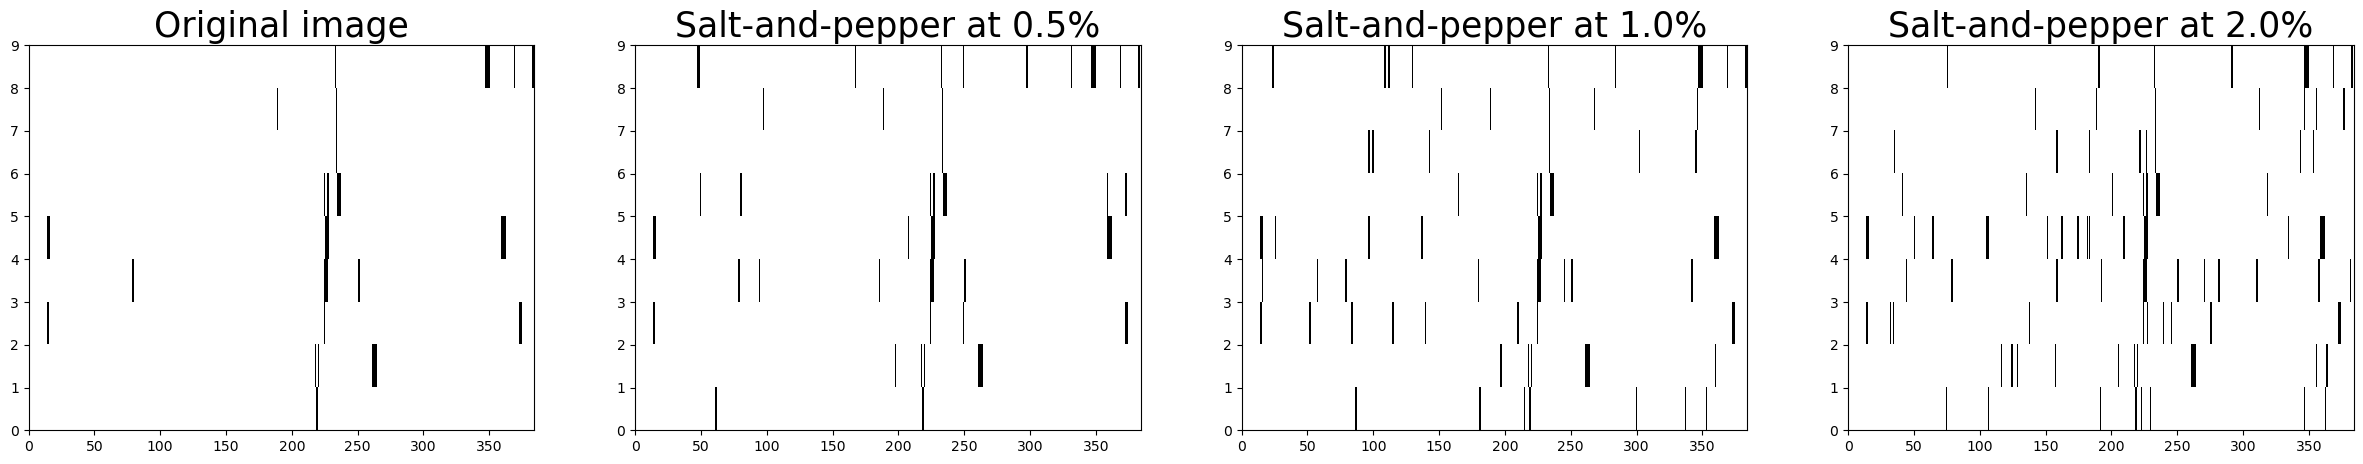

In [14]:
image = test_images[2]
noise_percents = [0.005, 0.01, 0.02] # 0.01 --> 1% added noise

plt.figure(figsize=(7.5*(len(noise_percents)+1), 5))
plt.subplot(1, len(noise_percents)+1, 1); plt.imshow(image < 0.5, aspect='auto', extent=(0, 384, 0, 9), cmap=plt.get_cmap('gray'), interpolation='none'); plt.title('Original image', fontsize=25)

for i, noise_percent in enumerate(noise_percents):
    noisy_image, noised_percent = add_noise(image, noise_percent)
    print(f'Noise percent = {noise_percent*100}% ==> actual added percent = {noised_percent*100:.3f}%')
    plt.subplot(1, len(noise_percents)+1, i+2); plt.imshow(noisy_image < 0.5, aspect='auto', extent=(0, 384, 0, 9), cmap=plt.get_cmap('gray'), interpolation='none'); plt.title(f'Salt-and-pepper at {noise_percent*100}%', fontsize=25)

plt.savefig('salt_and_pepper.jpg', dpi=300, bbox_inches='tight')
plt.show()

We also need to fine-tune the two hyperparameters of the method: the number of iterations $n$ and the value of the *noise percent* to add.

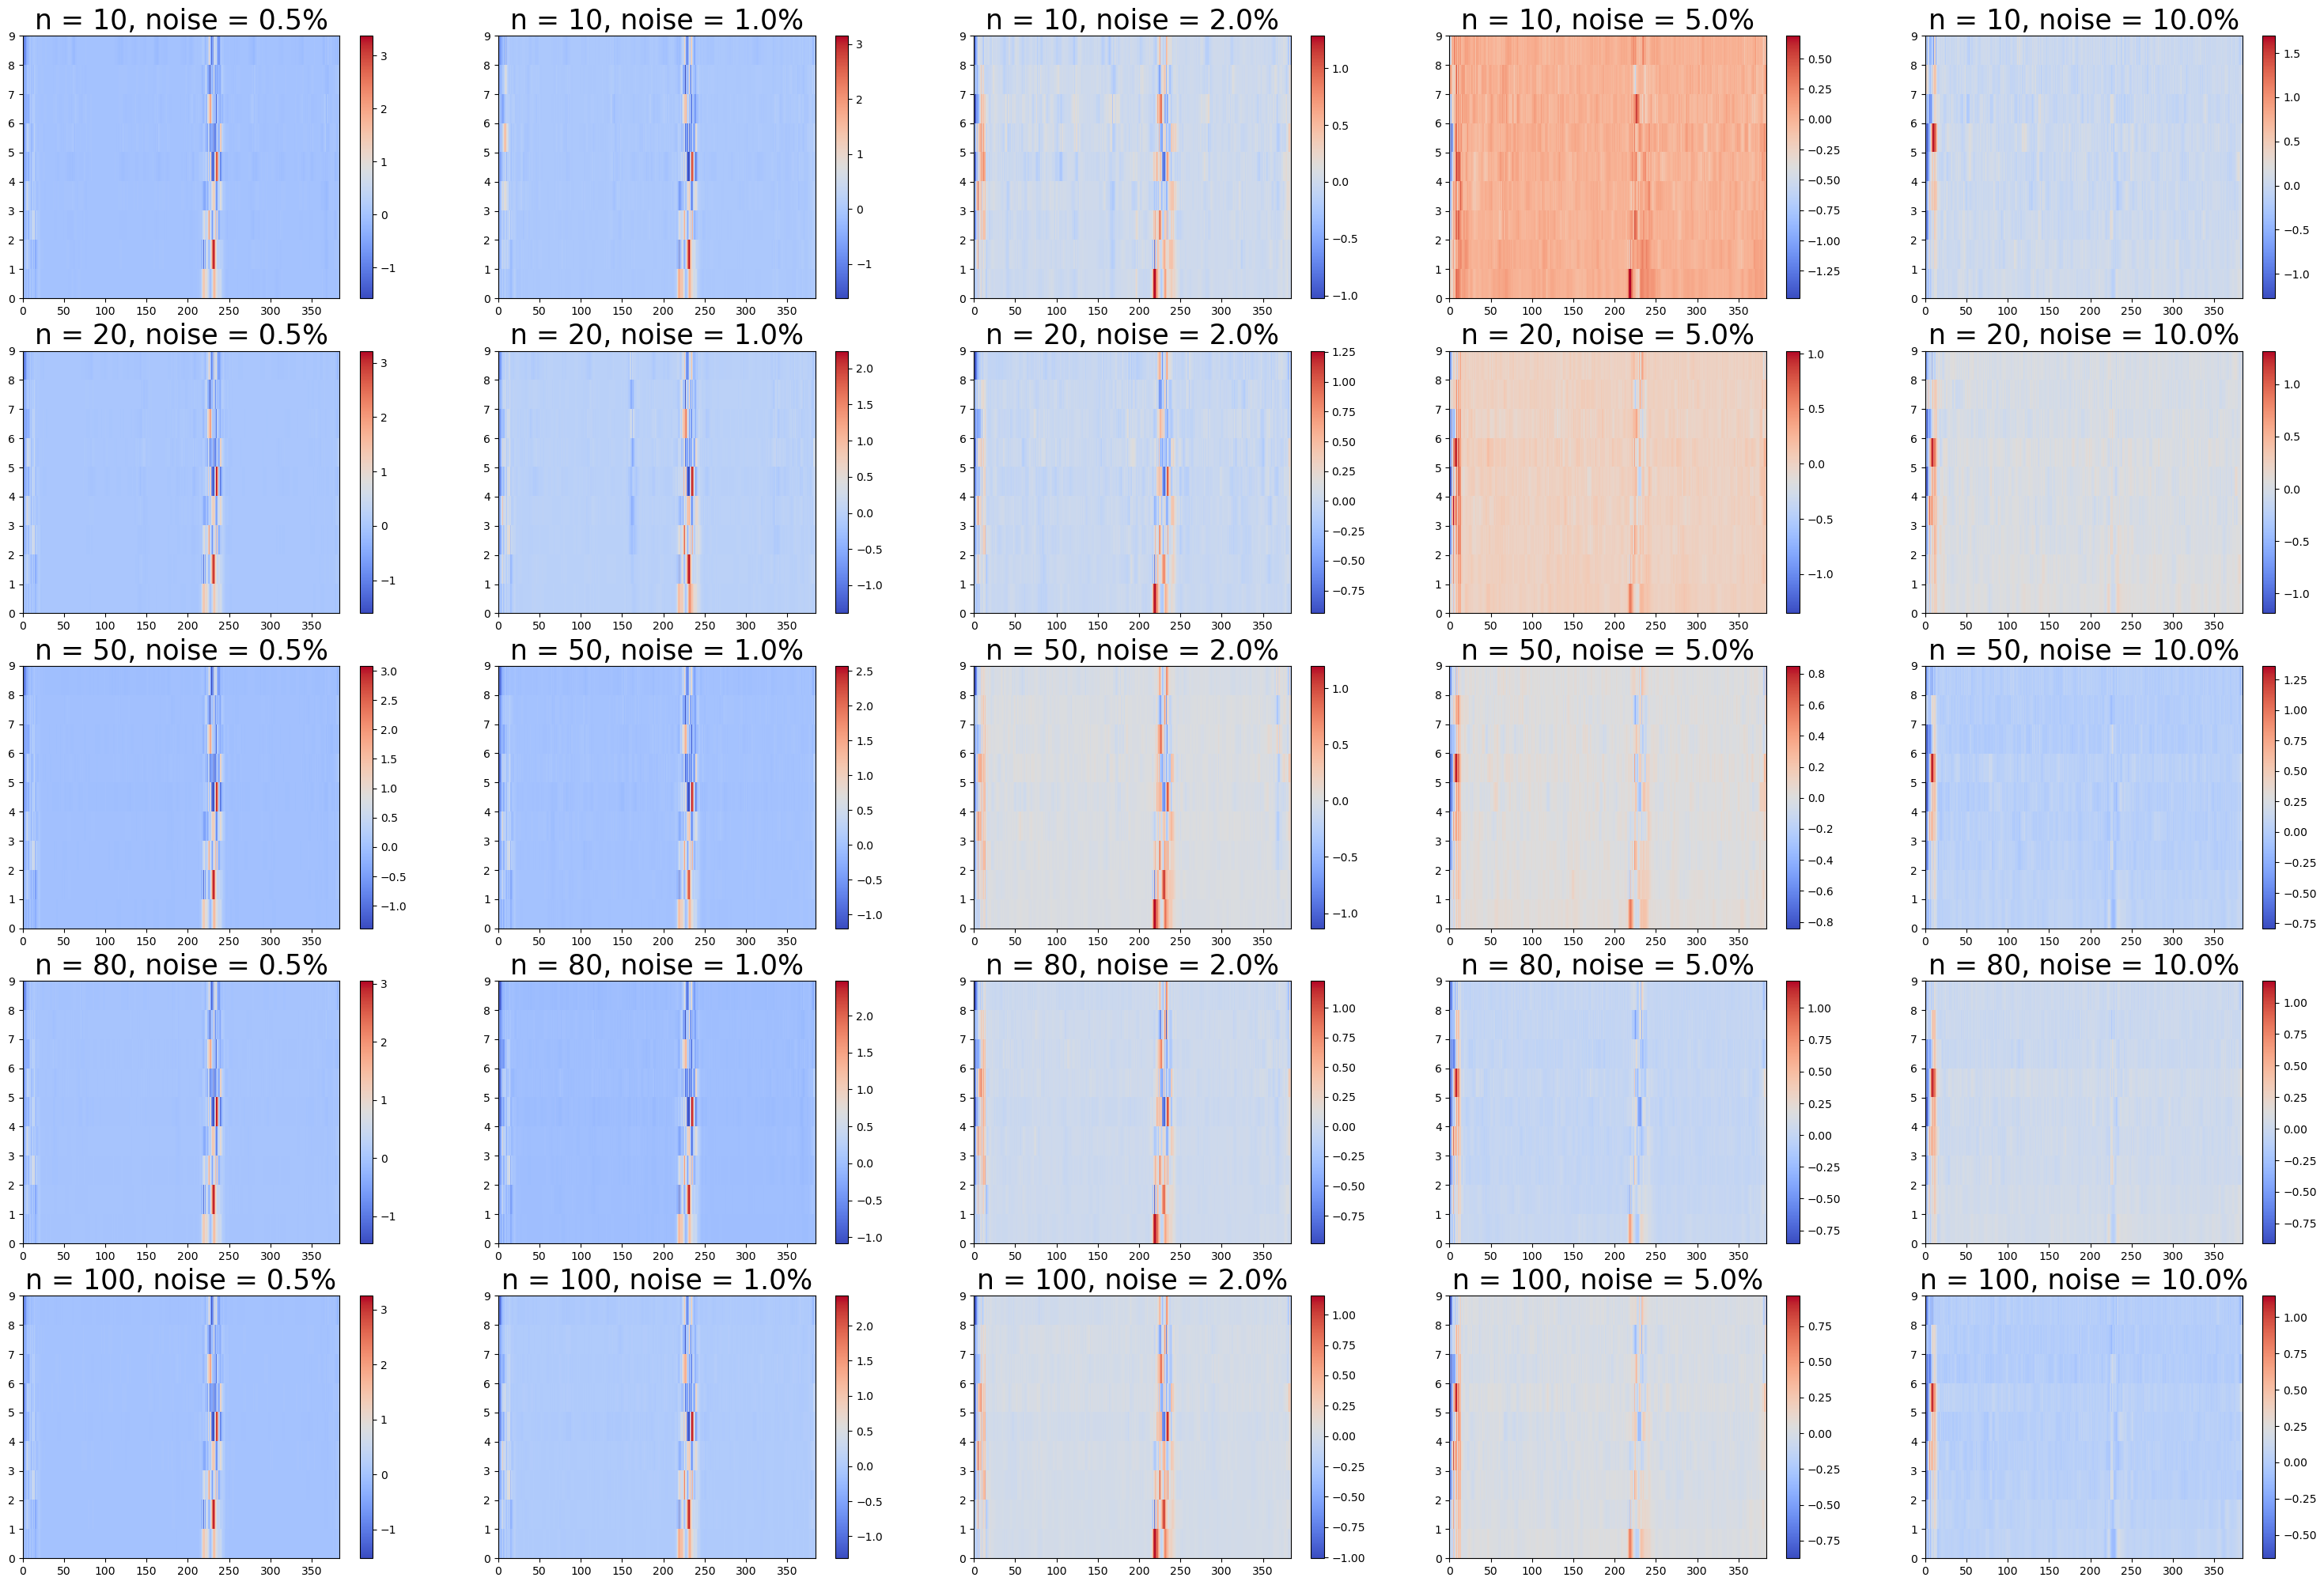

In [9]:
image = test_images[2]

ns = [10, 20, 50, 80, 100]
noise_percents = [0.005, 0.01, 0.02, 0.05, 0.1]
cont = 1

plt.figure(figsize=(7.5*5, 5*5))
for n in ns:
    for noise_percent in noise_percents:
        sg = smoothgrad(model, image, n, noise_percent)

        plt.subplot(5, 5, cont)
        plt.imshow(sg, aspect='auto', extent=(0, 384, 0, 9), cmap='coolwarm', interpolation='none')
        plt.colorbar()
        plt.title(f'n = {n}, noise = {noise_percent*100}%', fontsize=25)
        cont += 1

plt.savefig('noise_comparison.jpg', dpi=300, bbox_inches='tight')
plt.show()

The best option seems to be $n=100$ and *noise percent* $= 2\%$.

### Interesting study cases:

We can now analyze specific images and observe how the network provides predictions according to the highlighted feature on the heatmaps.

Below each plot, one can also notice the real and predicted values for the corresponding feature.

#### a. Selected events inspection

We can now inspect specific correctly or wrongly selected images and provide the related explanations from the network.
Note that we have a correct selection when the model predicts a $pt_{pred} > 15$ GeV given that $pt_{true} > 15$ GeV.

We can do that by first constructing a "*confusion matrix*" with the ```True/False Positives/Negatives``` events and then inspect each of these classification regions.

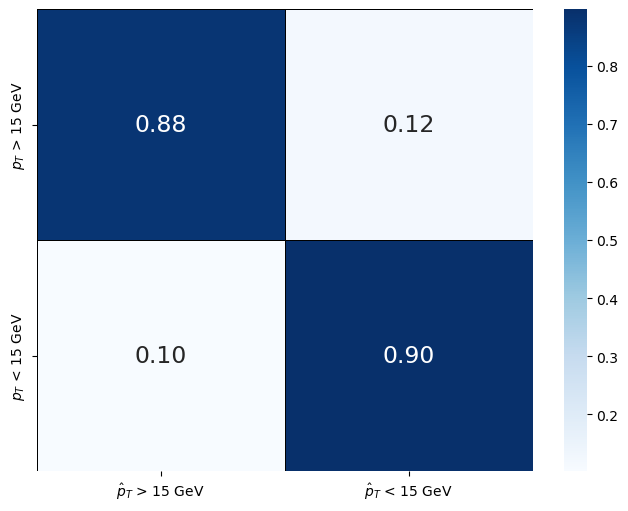

In [11]:
tp_index, fn_index, fp_index, tn_index, cm_plot = plot_cm(compare_df)

##### a.1. Correctly selected events inspection

Let's now evaluate the explanations of the network with the correctly selected images (i.e. where particles have **both** actual and predicted $pt >$ or $< 15$ GeV) by visualizing the related heatmaps.

We can notice how accurately the plots highlight regions with the pattern of the muons and do not consider other regions with noise.

There are 25127 true positives selected events.
There are 59210 true negatives selected events.

##################################################  True Positives inspection  ##################################################
1/1 [==============================] - 0s 20ms/step


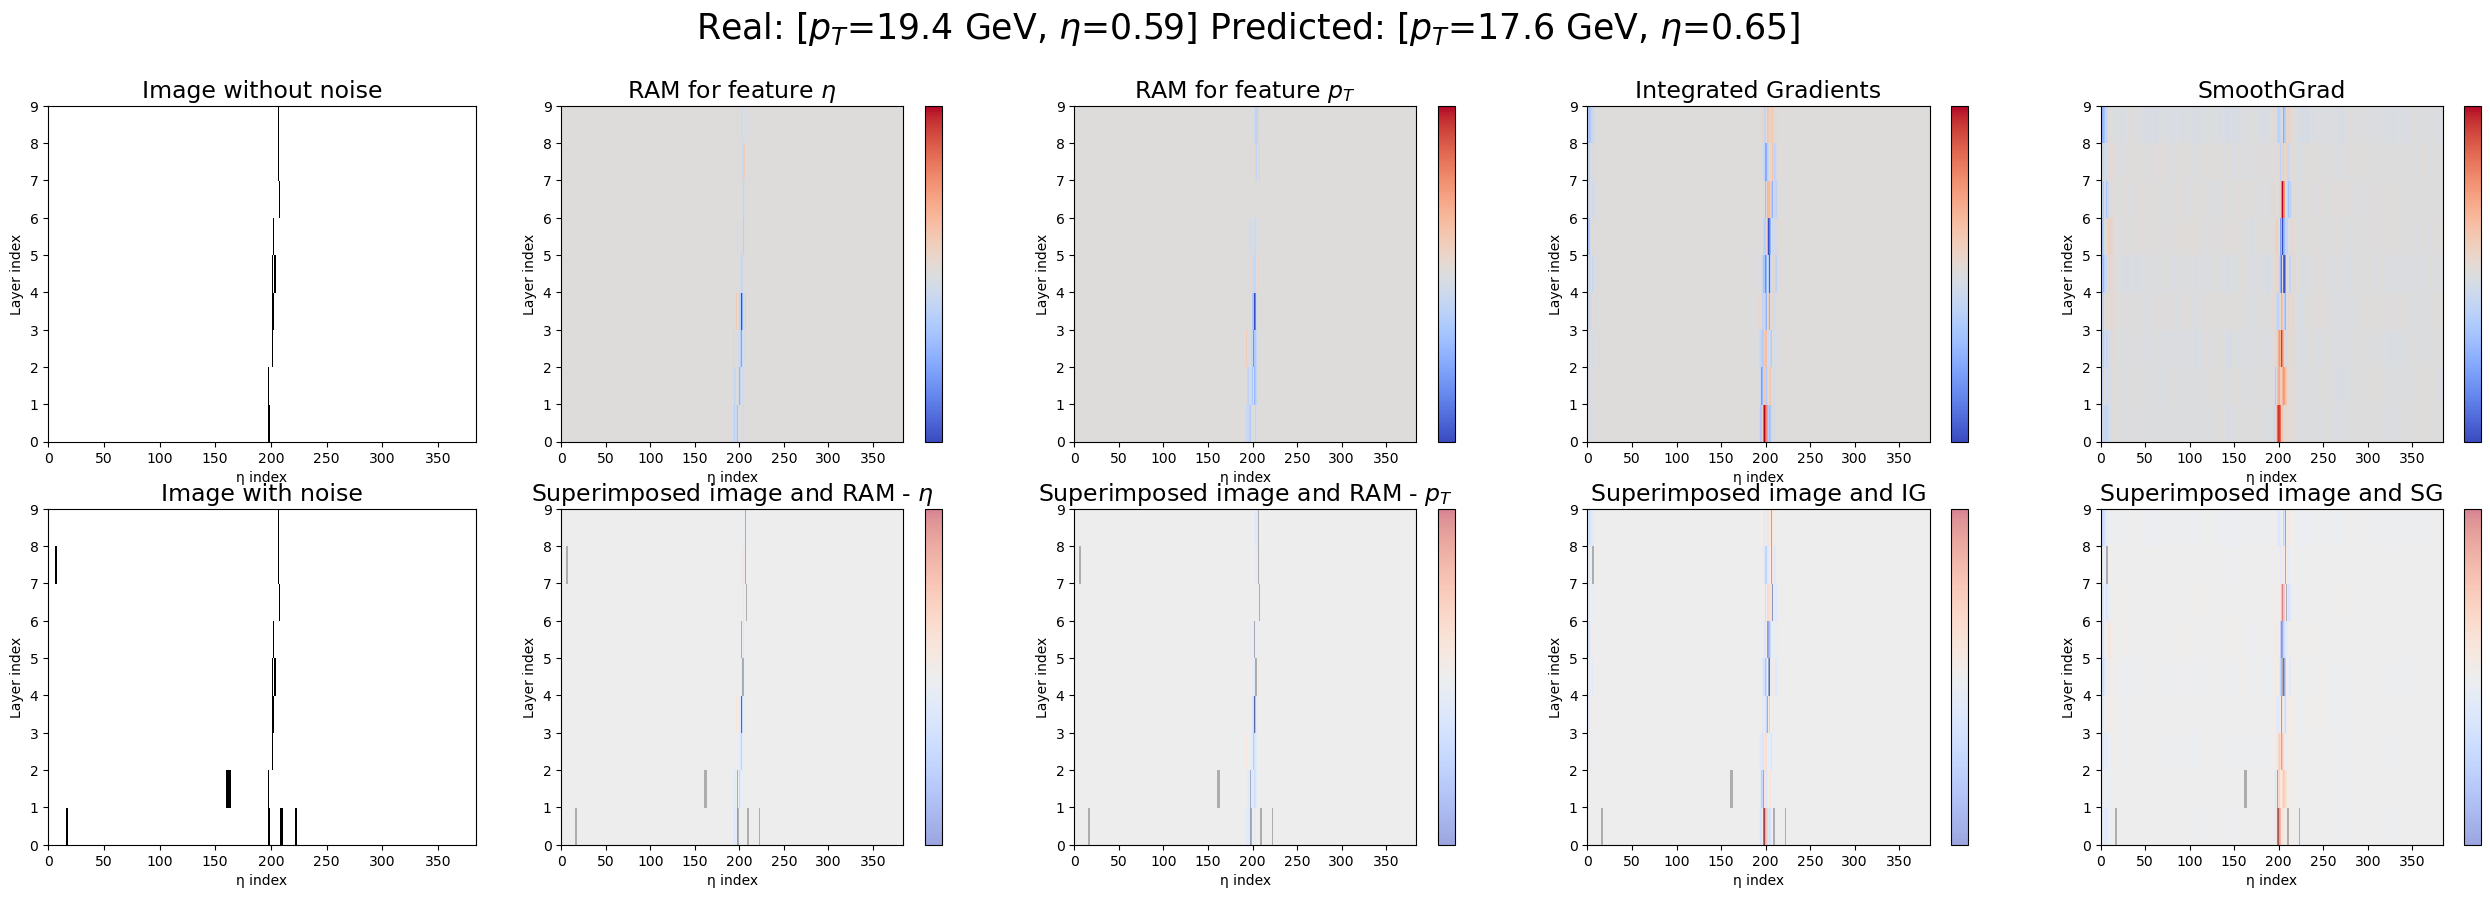

Index: 35076

 ---------------------------------------------------------------------------------------------------------------------------------------------------------------- 

##################################################  True Negatives inspection  ##################################################
1/1 [==============================] - 0s 29ms/step


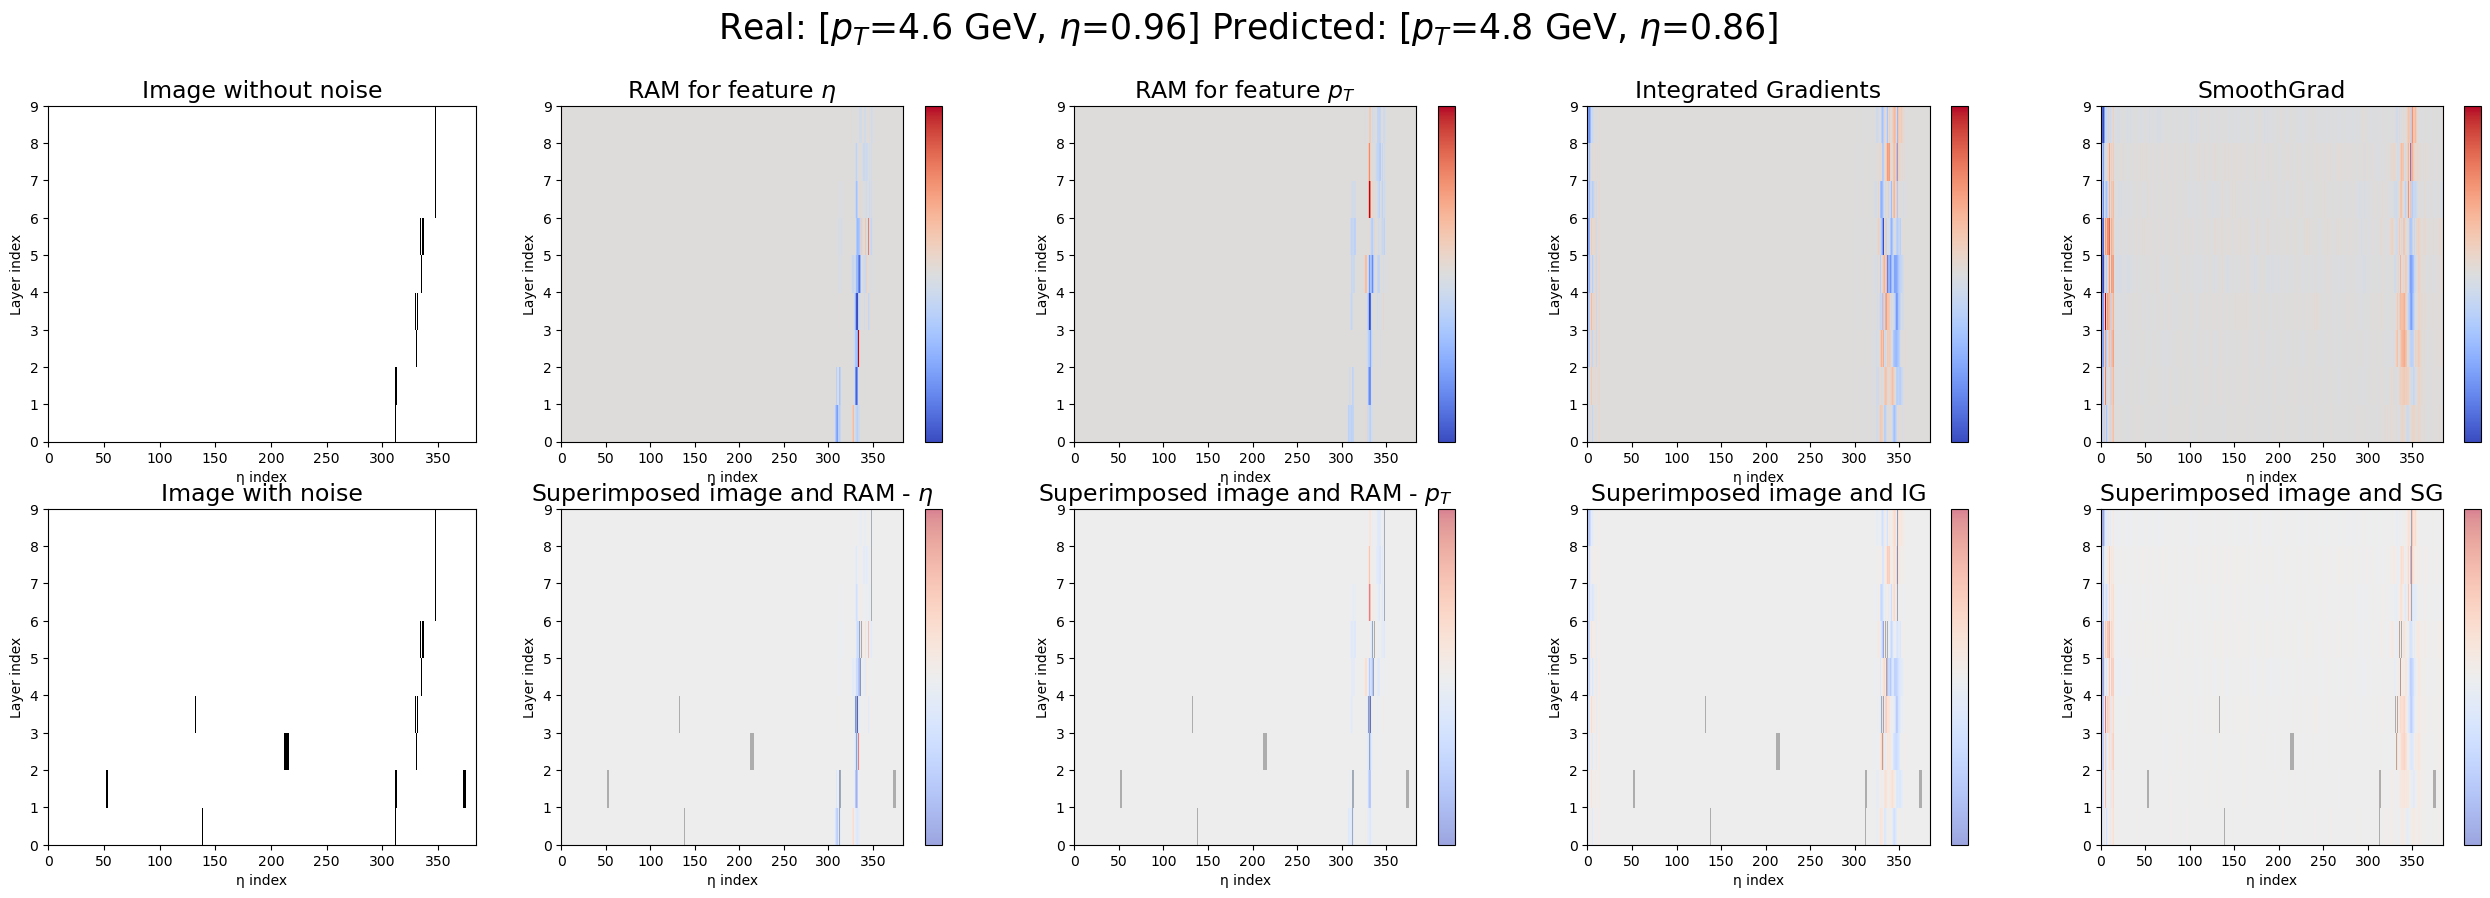

Index: 14540

 ---------------------------------------------------------------------------------------------------------------------------------------------------------------- 



In [13]:
# Inspect correctly selected events
print(f'There are {len(tp_index)} true positives selected events.')
print(f'There are {len(tn_index)} true negatives selected events.\n')

# TP inspection
print('#'*50, ' True Positives inspection ', '#'*50)
index = random.choice(tp_index)
ram_pt, ram_eta, ig, sg = get_heatmaps(model, ram_model, test_images[index])
plot_explanation(test_images[index], test_images_without_noise[index], ram_eta, ram_pt, ig, sg, test_labels[index], y_hat[index], index, save=True)
print(f'Index: {index}')
print('\n', '-'*160, '\n')

# TN inspection
print('#'*50, ' True Negatives inspection ', '#'*50)
index = random.choice(tn_index)
ram_pt, ram_eta, ig, sg = get_heatmaps(model, ram_model, test_images[index])
plot_explanation(test_images[index], test_images_without_noise[index], ram_eta, ram_pt, ig, sg, test_labels[index], y_hat[index], index, save=True)
print(f'Index: {index}')
print('\n', '-'*160, '\n')

##### a.2. Wrongly selected events inspection

Consequently, it is crucial to analyze the case where the network is wrong, namely it predicts a $pt_{pred} > 15$ GeV for images with a $pt_{true}$ under the threshold of interest of $10$ GeV and viceversa.

In particular, we focus on cases where the model error is higher than usual; as instance, filtering only when $|pt_{true} - pt_{pred}| > 5$ GeV.

In such situations, the plots contain "additional" highlighted patterns that clearly do not relate with the actual ones.

There are 6708 false positives selected events.
There are 3402 false negatives selected events.

############################################################  False Positives inspection  ############################################################
Index: 45962
1/1 [==============================] - 0s 20ms/step


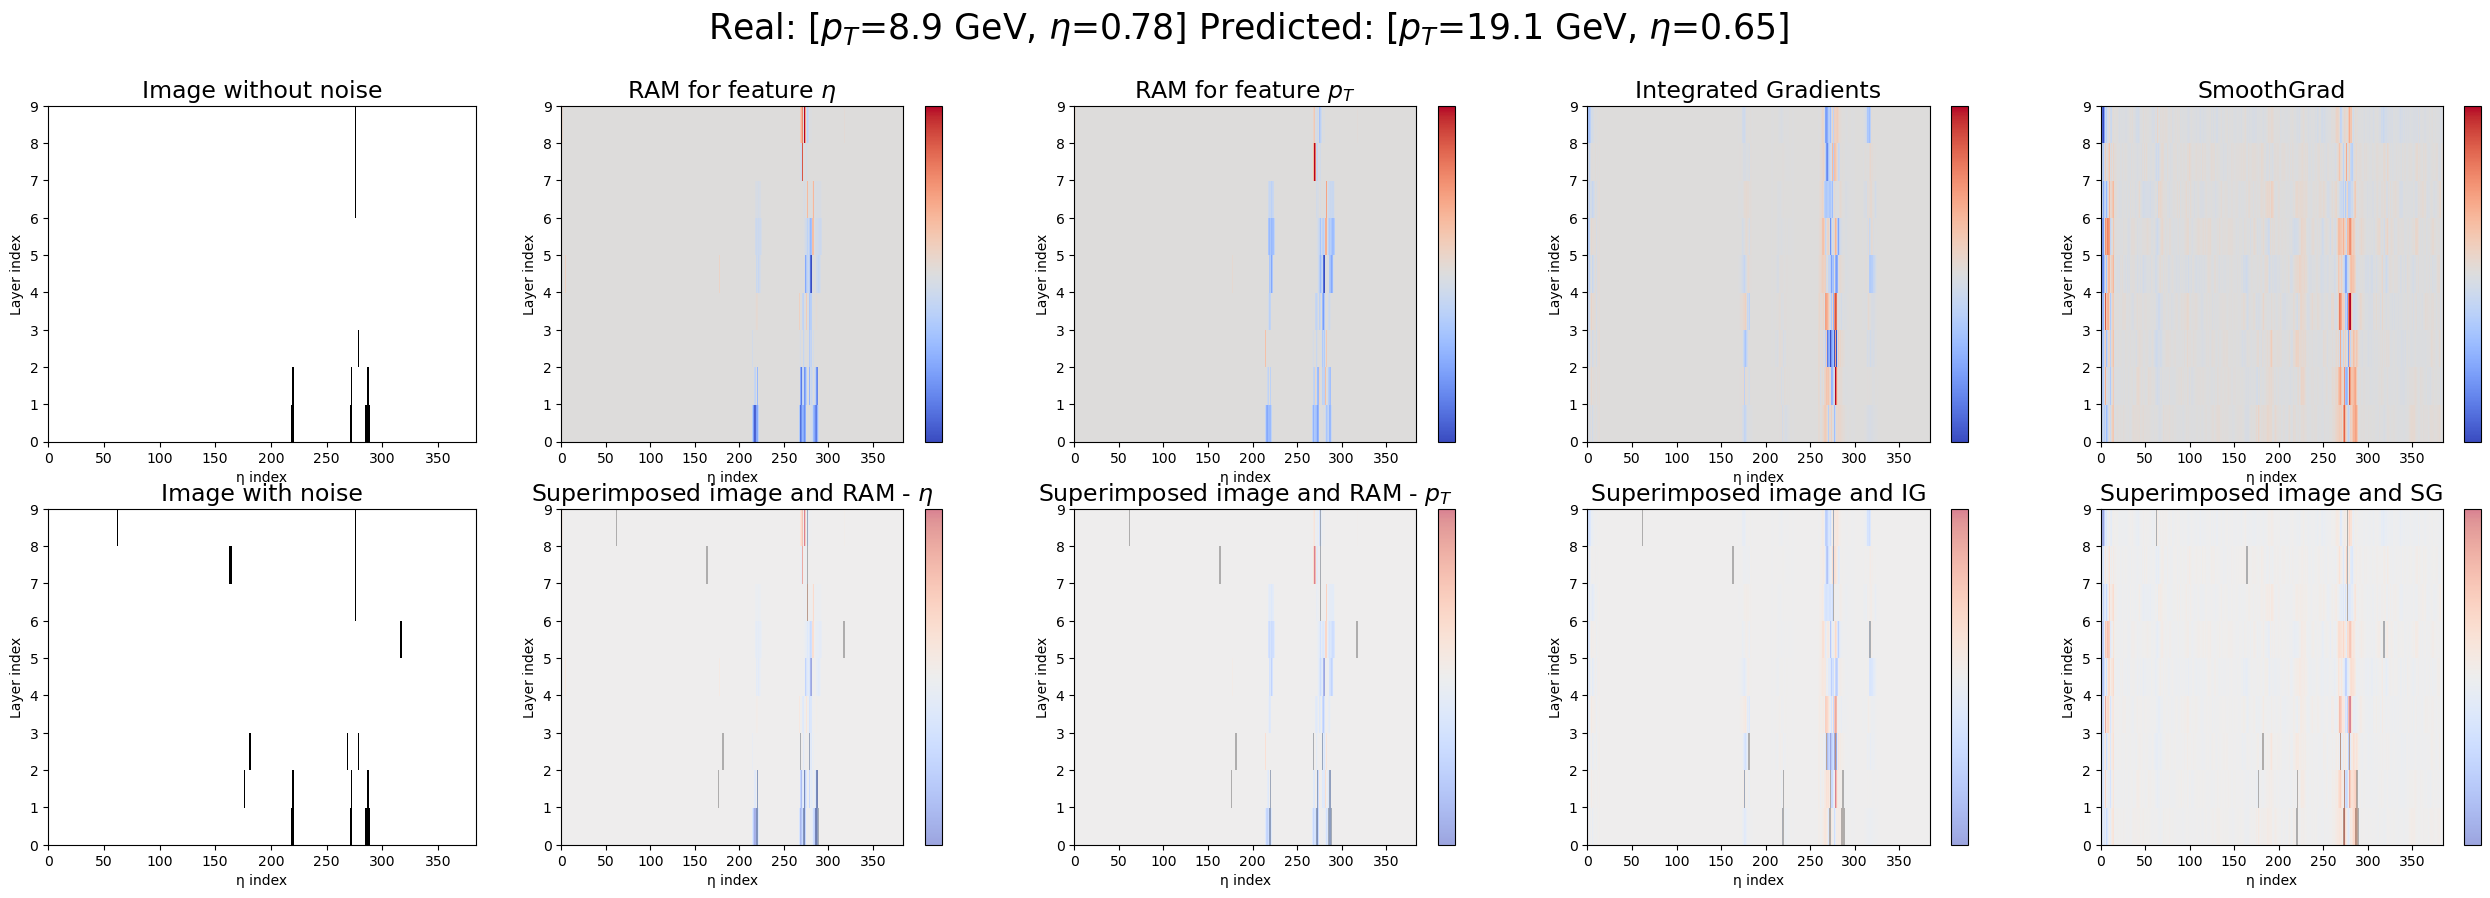


 ---------------------------------------------------------------------------------------------------------------------------------------------------------------- 

############################################################  False Negatives inspection  ############################################################
Index: 67114
1/1 [==============================] - 0s 22ms/step


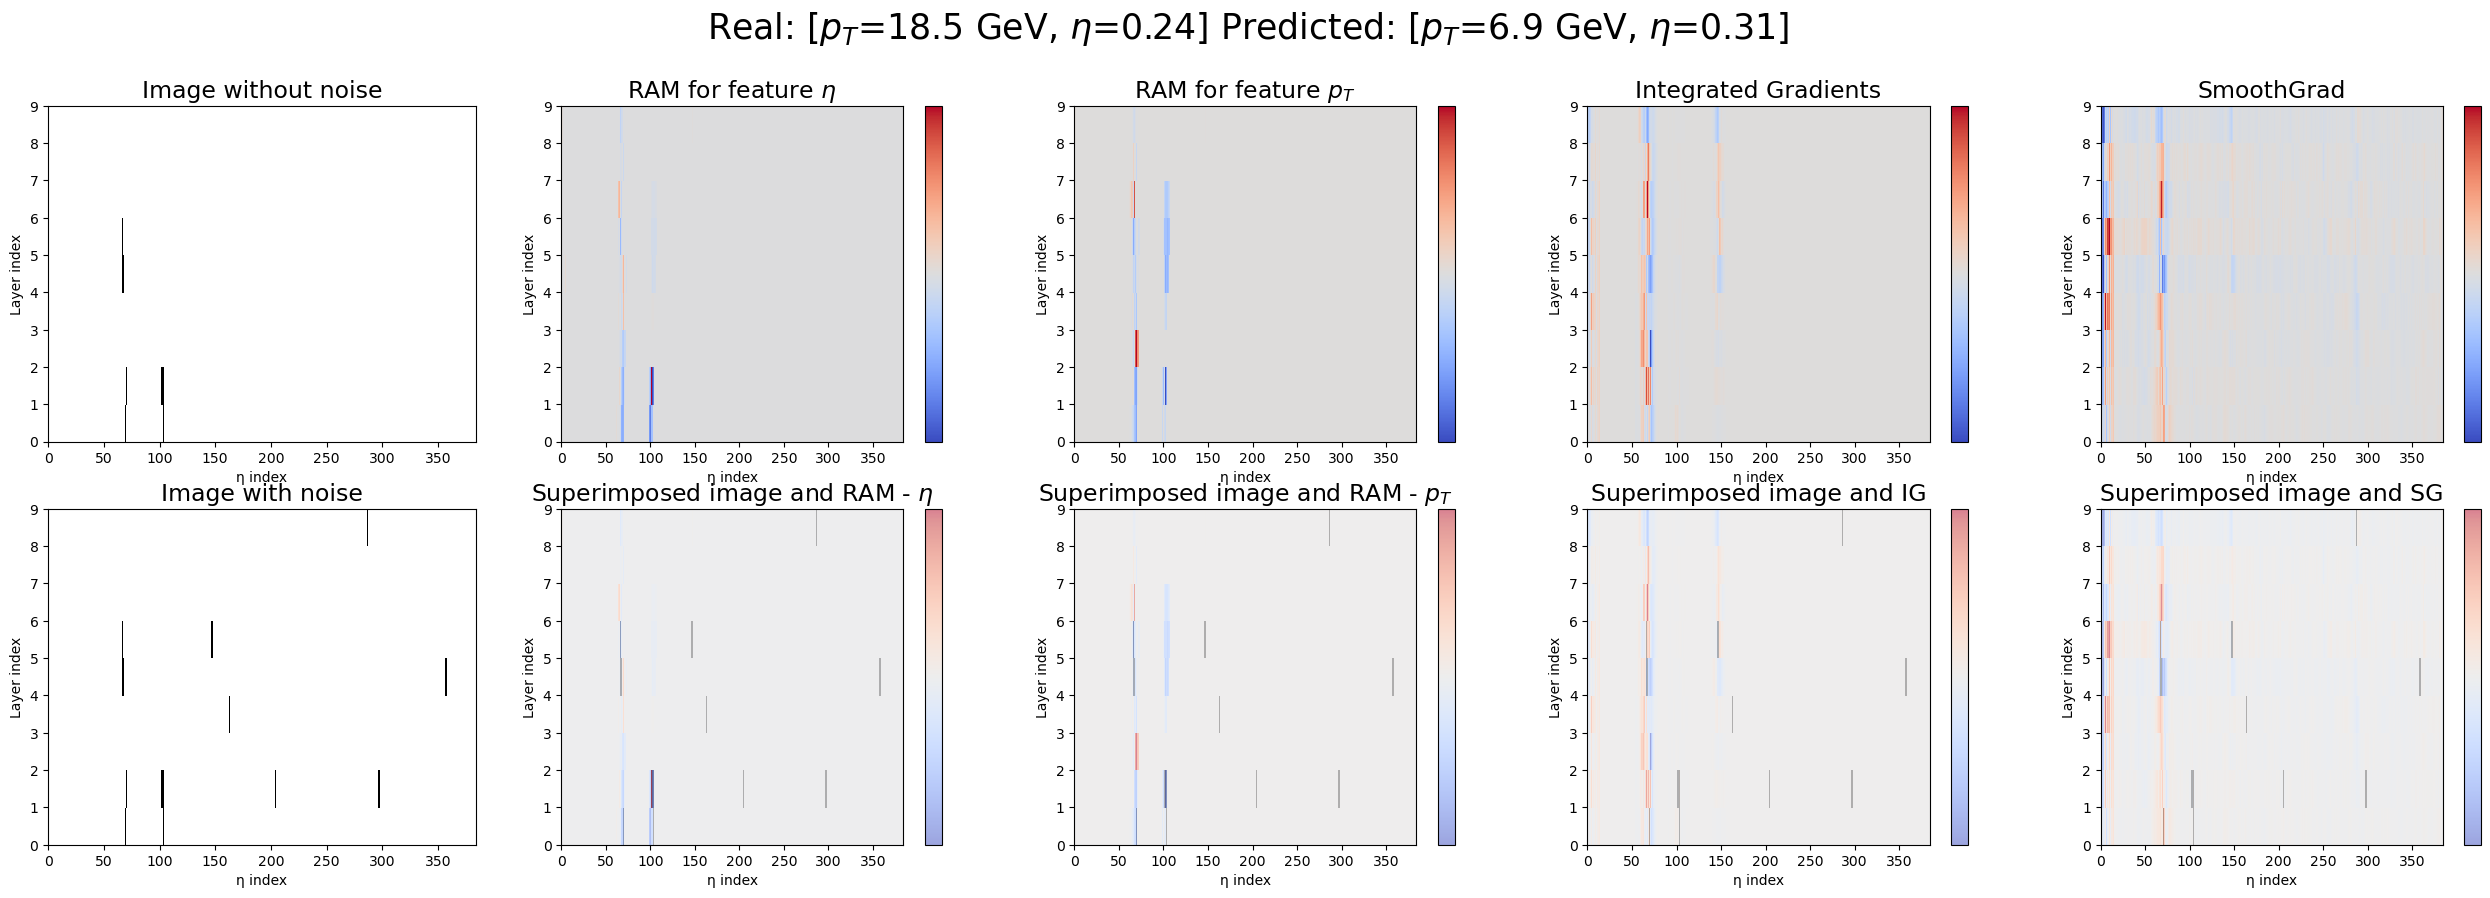


 ---------------------------------------------------------------------------------------------------------------------------------------------------------------- 



In [15]:
# Inspect not selected events: particles that have pt>15 GeV but predicted pt<10 GeV        
print(f'There are {len(fp_index)} false positives selected events.')
print(f'There are {len(fn_index)} false negatives selected events.\n')

# FP inspection
print('#'*60, ' False Positives inspection ', '#'*60)
index = random.choice(fp_index)
while abs(compare_df.iat[index, 0] - compare_df.iat[index, 2]) < 5:
    index = random.choice(fp_index)
print(f'Index: {index}')
ram_pt, ram_eta, ig, sg = get_heatmaps(model, ram_model, test_images[index])
plot_explanation(test_images[index], test_images_without_noise[index], ram_eta, ram_pt, ig, sg, test_labels[index], y_hat[index], index, save=True)
print('\n', '-'*160, '\n')

# FN inspection
print('#'*60, ' False Negatives inspection ', '#'*60)
index = random.choice(fn_index)
while abs(compare_df.iat[index, 0] - compare_df.iat[index, 2]) < 5:
    index = random.choice(fn_index)
print(f'Index: {index}')
ram_pt, ram_eta, ig, sg = get_heatmaps(model, ram_model, test_images[index])
plot_explanation(test_images[index], test_images_without_noise[index], ram_eta, ram_pt, ig, sg, test_labels[index], y_hat[index], index, save=True)
print('\n', '-'*160, '\n')

#### b. Only-noise images inspection

Finally, it's very interesting to see how the network behaves with images containing only noise and no effective patterns of the particles.

In [16]:
# what does the model predict for only-noise images?
# how many of them are predicted with a pt>10 GeV? Inspect them
# ! gdown --id 1nKHHj6ZqbS1SGkH5OYpezbYujbRlXxsi
# print('\nUnzipping data...')
# ! unzip -q images_only_noise.zip
# ! rm -rf images_only_noise.zip

print('\nLoading only-noise images...')
noise_images = np.load('../images_only_noise/images_only_noise.npy')
print('\nLoading completed.')

# checking shapes of npy array
print(noise_images.shape)

In [ ]:
# predicting only-noise images
noise_y_hat = model.predict(noise_images)
noise_df = pd.DataFrame(noise_y_hat, columns=['pt_pred', 'eta_pred'])
noise_df.head(10)

,pt_pred,eta_pred
0,11.704197,0.227292
1,12.182451,0.190195
2,10.822639,0.150607
3,11.827906,0.227721
4,11.715958,0.227332
5,11.099725,0.228097
6,12.240672,0.217559
7,10.890645,0.236247
8,11.878897,0.224384
9,11.788917,0.227586


In [15]:
# indices of the selected only-noises events 
onlyNoise_index = []
for i, elem in noise_df.iterrows():
    if elem['pt_pred'] > 15:
        onlyNoise_index.append(i)

There are 1389 selected events among the only-noise images. 0.1471%

############################################################  Only Noise inspection  ############################################################
1/1 [==============================] - 0s 20ms/step


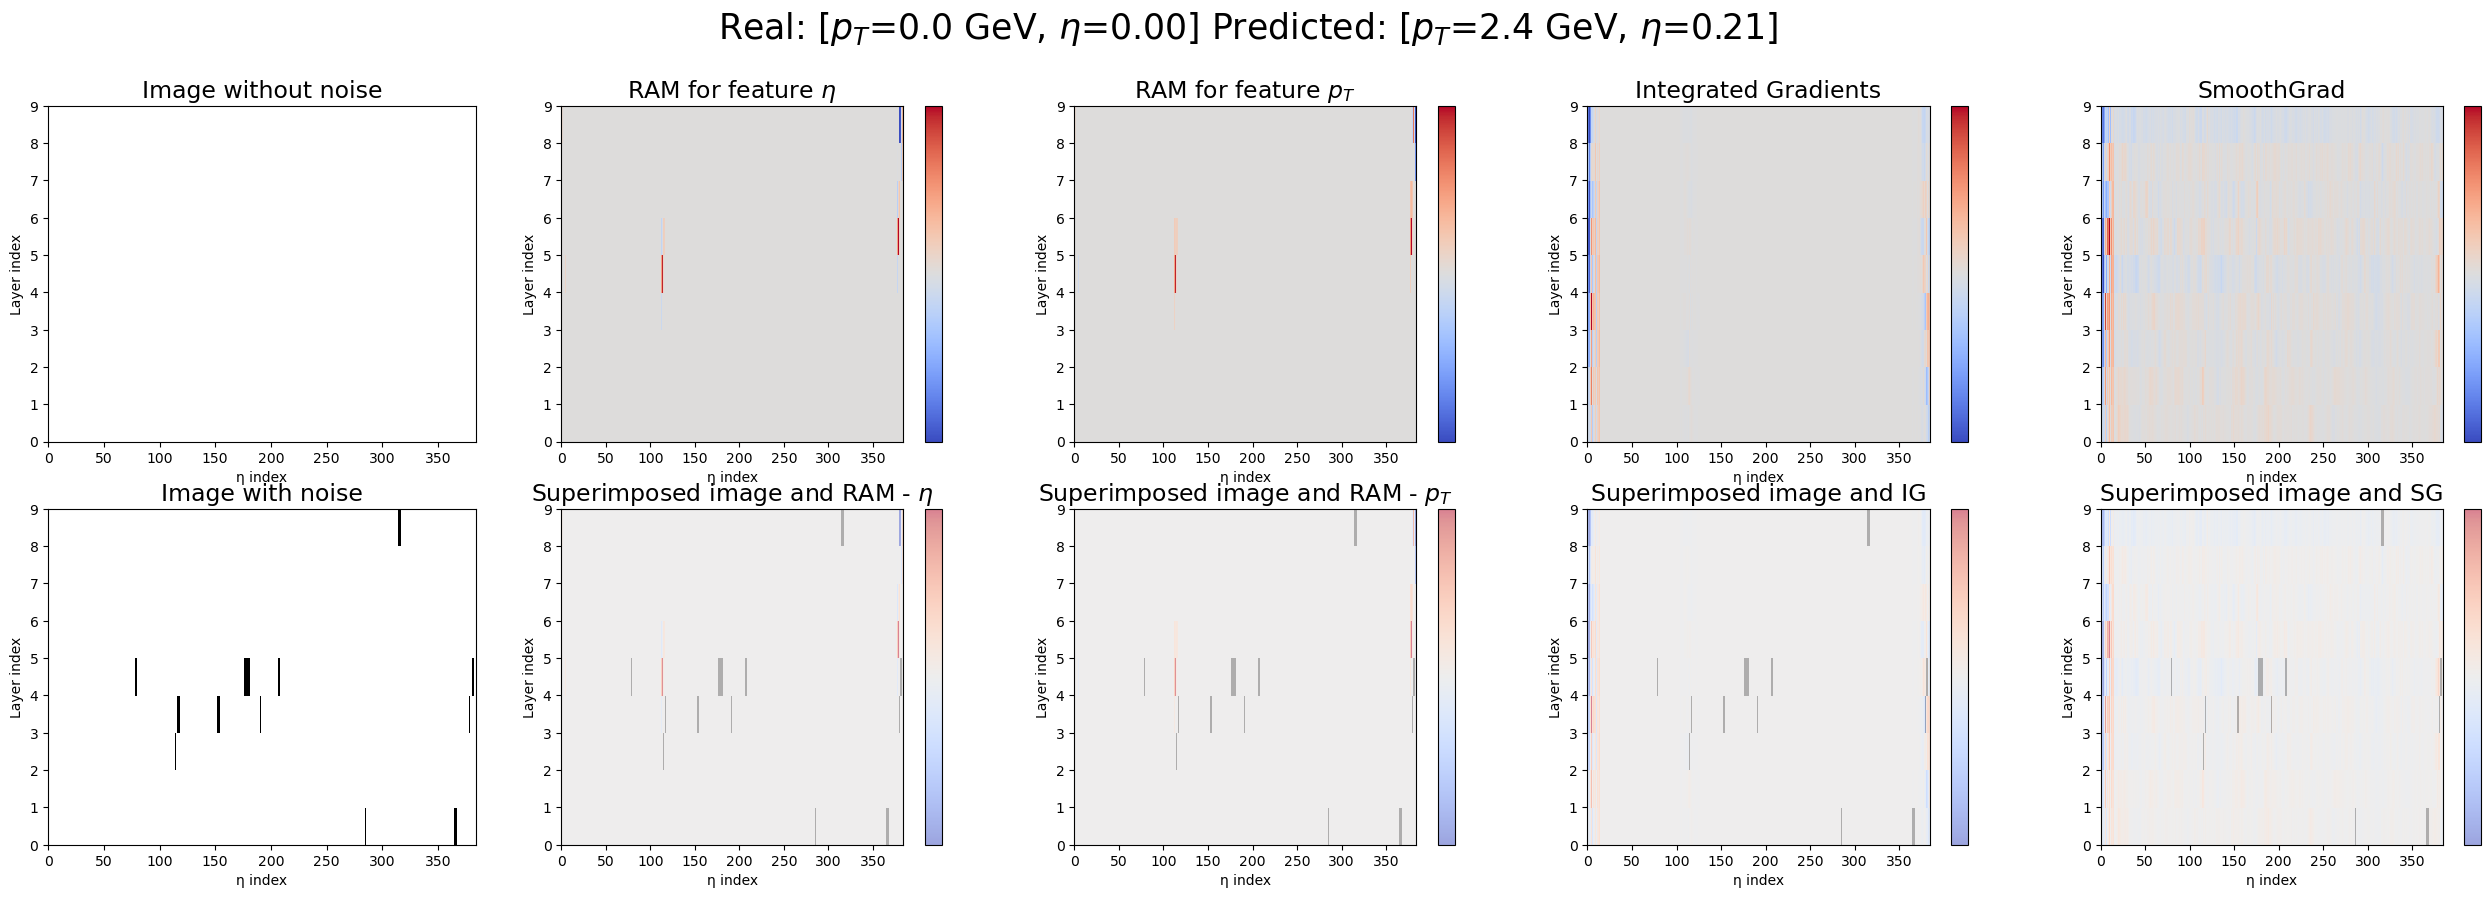

Index: 816625

 ---------------------------------------------------------------------------------------------------------------------------------------------------------------- 

1/1 [==============================] - 0s 25ms/step


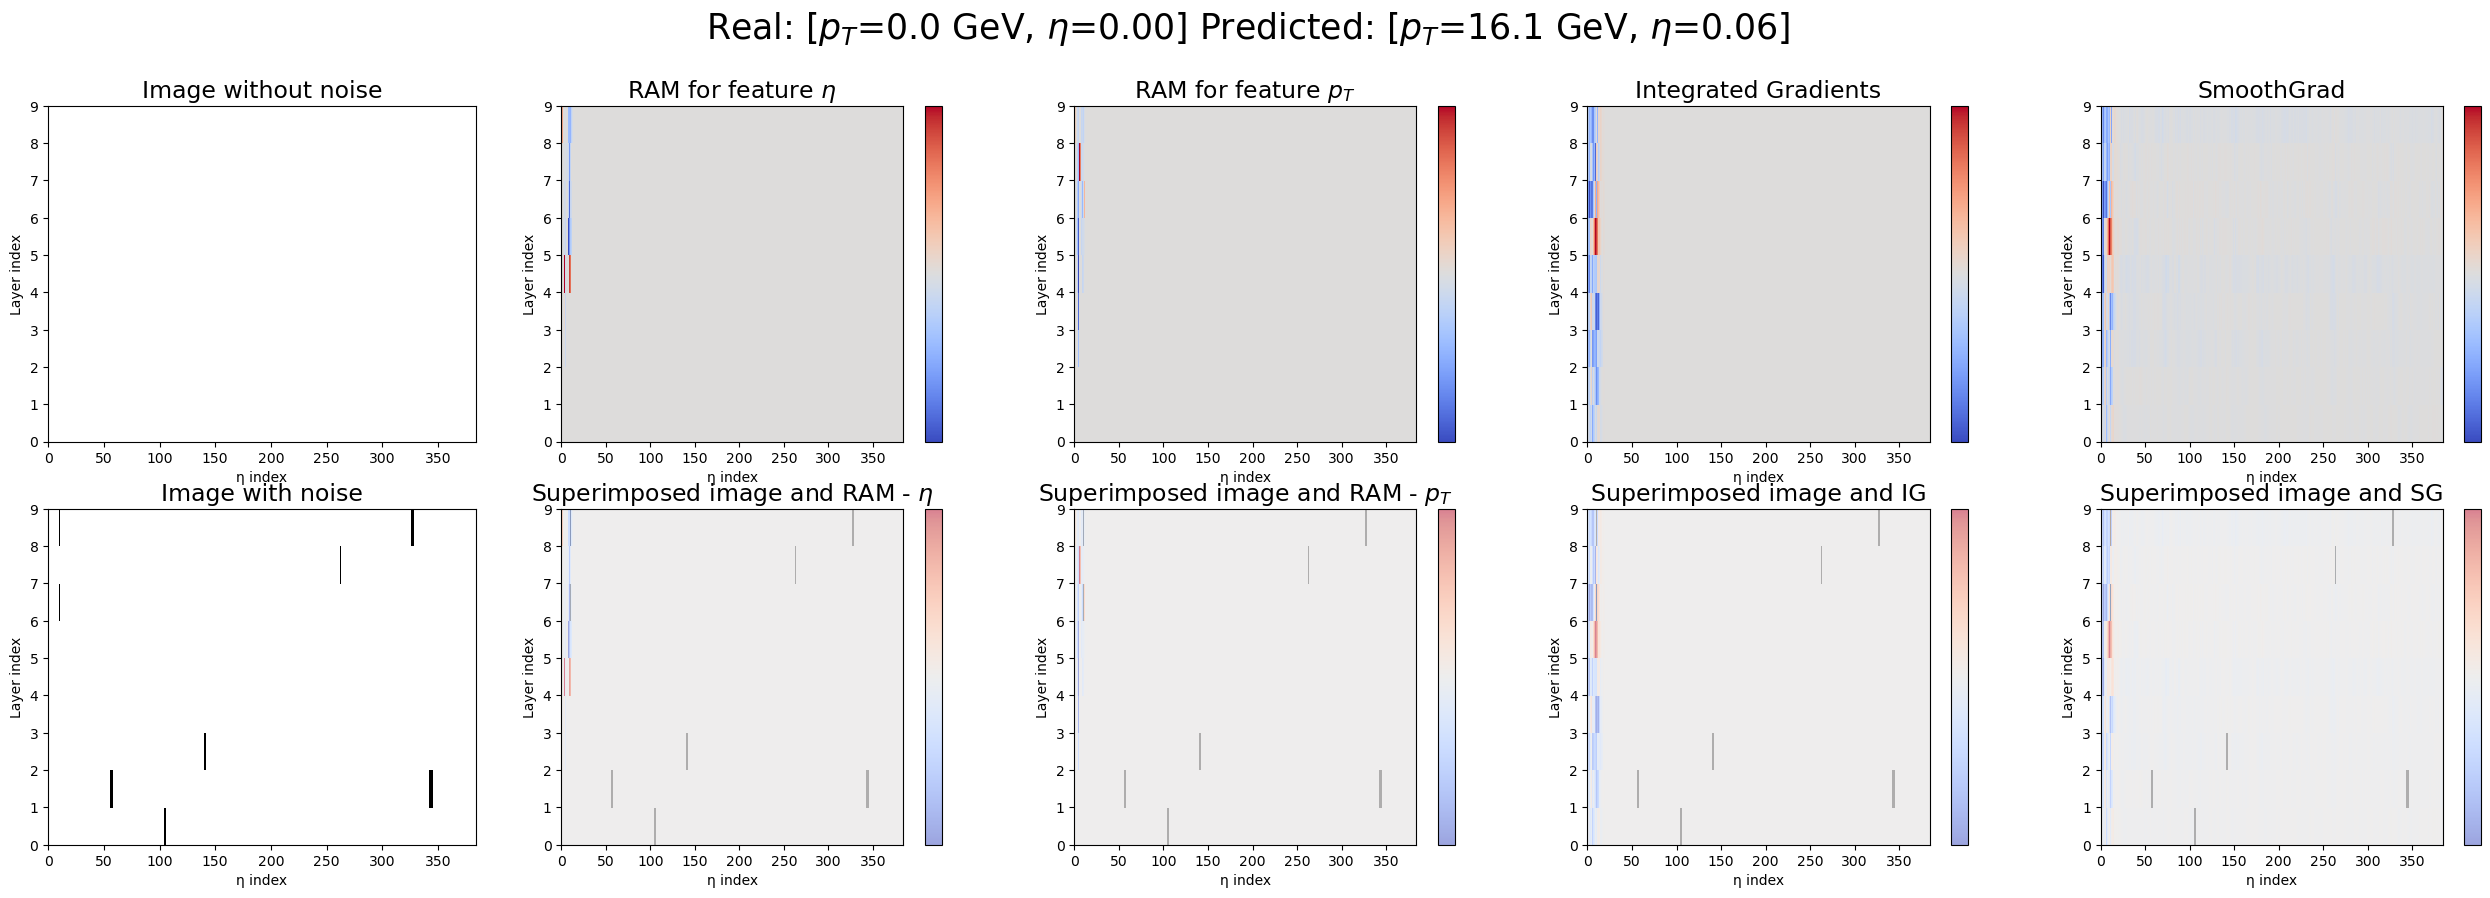

Index: 663329

 ---------------------------------------------------------------------------------------------------------------------------------------------------------------- 



In [17]:
print(f'There are {len(onlyNoise_index)} selected events among the only-noise images. {len(onlyNoise_index)/len(noise_images)*100:0.4f}%\n')
print('#'*60, ' Only Noise inspection ', '#'*60)

# explaining 2 random images of this list
# plotted, lowest and high predicted pt
for _ in range(2):
    index = random.choice(onlyNoise_index)
    ram_pt, ram_eta, ig, sg = get_heatmaps(model, ram_model, noise_images[index])
    plot_explanation(noise_images[index], np.zeros_like(noise_images[index]), ram_eta, ram_pt, ig, sg, [0.0, 0.0], noise_y_hat[index], index, save=True)
    print(f'Index: {index}')
    print('\n', '-'*160, '\n')